# Visualisation des données de la campagne "visite page produit" de l'annonceur 2

## Visualisation des données brutes

In [1]:
# fichiers contenant les fonctions utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from premiere_analyse import *
from part1 import *
from part2 import *
from part3 import *
from testZ import *
import scipy.stats as st
import statsmodels.stats as sms
from IPython.display import display, Markdown
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.stattools as sto
from pandas import DataFrame
import seaborn as sns
import warnings

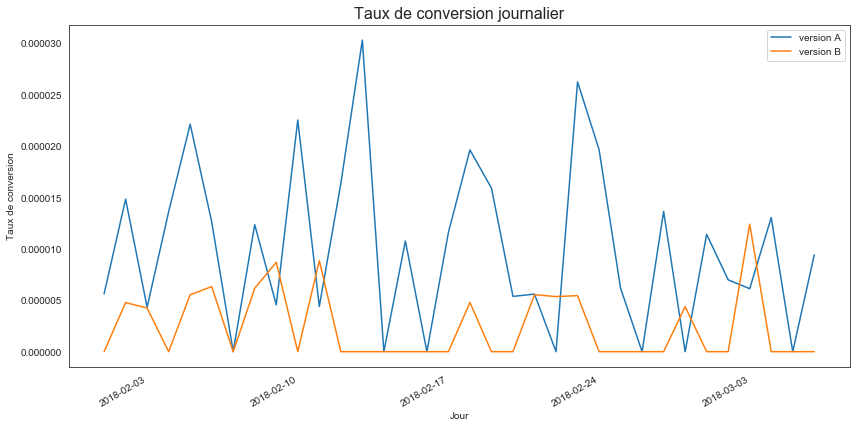

In [2]:
datasetA = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitA')
datasetB = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitB')
plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, datasetA['conv_rate'], marker='', linestyle='-')
plt.plot(datasetA.index, datasetB['conv_rate'])
plt.xlabel('Jour')
plt.ylabel('Taux de conversion')
plt.title('Taux de conversion journalier', fontsize=16)
plt.legend(['version A', 'version B'], loc='best')
plt.show()

On voit ainsi que la version B semble moins efficace que la version A, ce qui reste à démontrer via un test d'hypothèses.

## Différence relative des taux de conversion

On regarde si le niveau d'agrégation (jour ou semaine) permettrait d'établir une différence relative importante entre les taux de conversions issus des deux versions. On notera toutefois que cette différence relative ne peut être calculée pour certains jours puisque le taux de conversion de la version A est parfois nul.

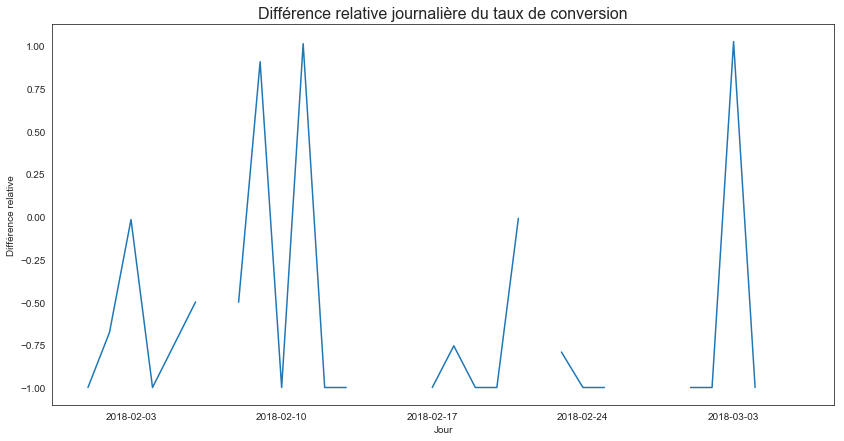

In [3]:
daily_relative_difference = (datasetB['conv_rate'] - datasetA['conv_rate']) / datasetA['conv_rate']

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(datasetA.index, daily_relative_difference)
plt.xlabel('Jour')
plt.ylabel('Différence relative')
plt.title('Différence relative journalière du taux de conversion', fontsize=16)
plt.show()

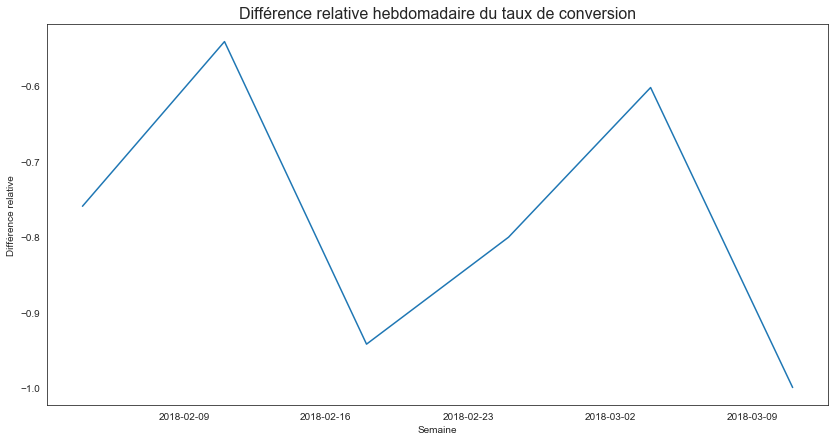

In [4]:
weekly_datasetA = datasetA.resample('W').sum()
weekly_datasetA['conv_rate'] = weekly_datasetA['n_convs'] / weekly_datasetA['total_impressions']

weekly_datasetB = datasetB.resample('W').sum()
weekly_datasetB['conv_rate'] = weekly_datasetB['n_convs'] / weekly_datasetB['total_impressions']

weekly_relative_difference = (weekly_datasetB - weekly_datasetA) / weekly_datasetA

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(weekly_relative_difference.index, weekly_relative_difference['conv_rate'])
plt.xlabel('Semaine')
plt.ylabel('Différence relative')
plt.title('Différence relative hebdomadaire du taux de conversion', fontsize=16)
plt.show()

Il semblerait ainsi que sur la plage temporelle étudiée, la différence relative était négative décroisse jusqu'à atteindre la valeur -1 : d'un point de vue hebdomadaire, le taux de conversion sous la version B était inférieur à celui sous la version A, et vers la fin de la campagne, la version B n'engendrait presque plus de conversion.

# Analyse des données de la campagne "visite page produit" de l'annonceur 2

## Stationnarité des données

On s'intéresse dans un premier temps à la stationnarité des données : le taux de conversion dépend-t-il du jour de la visite ? Y a-t-il des jours où le taux de conversion semble influencer la conversion des utilisateurs ?

In [5]:
adf_test(datasetA['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.559938e+00
p-value,8.430668e-09
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


In [6]:
adf_test(datasetB['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.159365e+00
p-value,7.236679e-08
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


Un test de Dickey-Fuller sur la série temporelle des taux de conversions journaliers pour la version A indique que celle-ci est stationnaire (p-value inférieure à 1%). De même, la série temporelle pour la version B indique que celle-ci est stationnaire.

In [7]:
adf_test(list(np.diff(datasetA['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-6.306489e+00
p-value,3.313809e-08
# of lags,3.000000e+00
# of observations,2.900000e+01
Critical Value (1%),-3.679060e+00
Critical Value (5%),-2.967882e+00
Critical Value (10%),-2.623158e+00


In [8]:
adf_test(list(np.diff(datasetB['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-8.350228e+00
p-value,3.008578e-13
# of lags,1.000000e+00
# of observations,3.100000e+01
Critical Value (1%),-3.661429e+00
Critical Value (5%),-2.960525e+00
Critical Value (10%),-2.619319e+00


On a toujours stationnarité des séries temporelles après différenciation.

## Saisonnalité des données

On essaie ensuite de voir si de la série temporelle on peut dégager certaines tendances : tendance globale, composante saisonnière et résidu, le but étant de voir si les taux de conversion peuvent être affectés par certains cycles temporels, et, le cas échéant, dans quelle mesure. Puisque nous travaillons avec des taux de conversion dont les valeurs peuvent être nulles, on se focalisera essentiellement sur des modèles additifs.

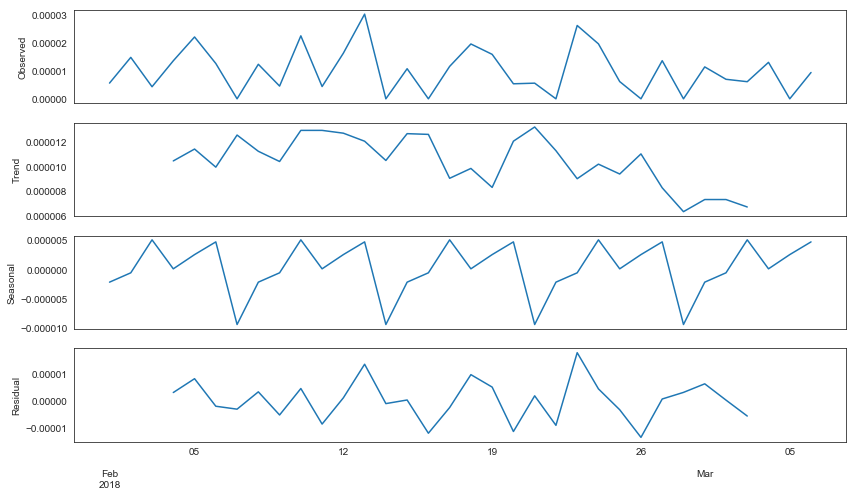

In [9]:
conversion_rate = datasetA['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

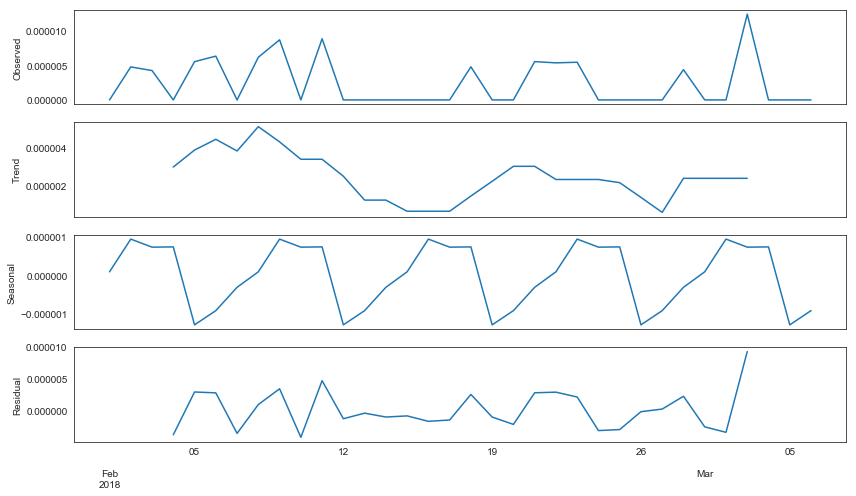

In [10]:
conversion_rate = datasetB['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

# Z-test : conclusion quant à l'efficacité du test A/B mené

## Z-test global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". En d'autres termes, l'hypothèse H1 traduit le fait que la version B a bel et bien une influence sur le taux de conversion.

In [11]:
from scipy.stats import norm
pA = sum(datasetA['n_convs']) / sum(datasetA['total_impressions'])
pB = sum(datasetB['n_convs']) / sum(datasetB['total_impressions'])

nA = sum(datasetA['total_impressions'])
nB = sum(datasetB['total_impressions'])

Z_value = (pA - pB) / np.sqrt(pA * (1 - pA) / nA + pB * (1 - pB) / nB)
p_val = 1 - norm.cdf(abs(Z_value)) + norm.cdf(-abs(Z_value))

print(p_val)

7.947137968280094e-08


On obtient une p-valeur inférieure aux seuils usuels de 10%, 5% ou 1%. On rejette donc l'hypothèse H0 et on en déduit alors que **la version B semble avoir plus d'influence sur le taux de conversion que la version A. En effet, comme vu précédemment, la version B semble moins efficace que la version A**.

## Z-test cumulé (pas journalier)

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ?

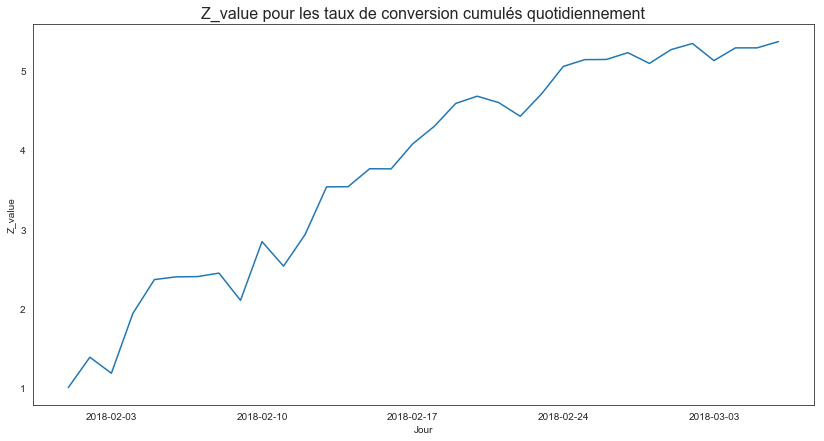

In [12]:
daily_cumsum_datasetA = datasetA[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetB = datasetB[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetA['conv_rate'] = daily_cumsum_datasetA['n_convs'] / daily_cumsum_datasetA['total_impressions']
daily_cumsum_datasetB['conv_rate'] = daily_cumsum_datasetB['n_convs'] / daily_cumsum_datasetB['total_impressions']

Z_value_1D = []
p_value_1D = []

for date in daily_cumsum_datasetA.index:
    pA = daily_cumsum_datasetA.loc[date]['conv_rate']
    nA = daily_cumsum_datasetA.loc[date]['total_impressions']
    pB = daily_cumsum_datasetB.loc[date]['conv_rate']
    nB = daily_cumsum_datasetB.loc[date]['total_impressions']
    Z_value_1D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_1D.append(1 - norm.cdf(abs(Z_value_1D[-1])) + norm.cdf(-abs(Z_value_1D[-1])))

        
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(daily_cumsum_datasetA.index, Z_value_1D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title('Z_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.show()

La Z-value est toujours positive. Cette valeur était du signe de la différence entre le taux de conversion sous version A et celui sous version B, cela nous indique qu'a priori, la version A était meilleure que la version B. Il reste à voir si cela peut être confirmé ou infirmé statistiquement. On s'intéresse ainsi à l'évoluation de la p-valeur.

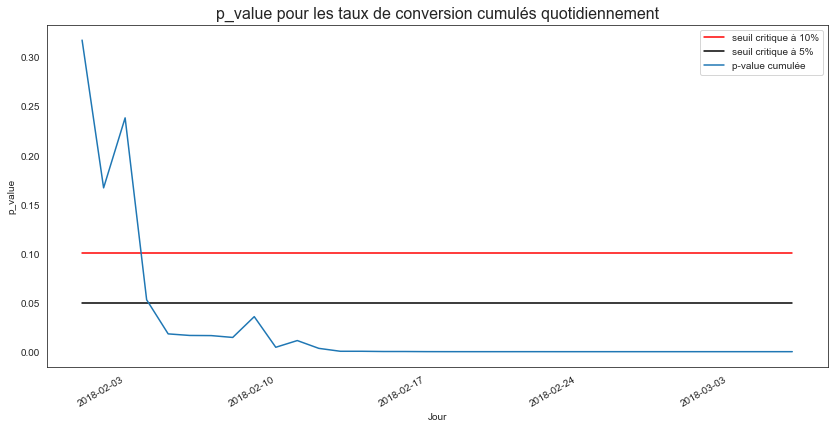

In [13]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, [0.1]*len(datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(datasetA.index, [0.05]*len(datasetA.index), marker='', linestyle='-', c='black')
plt.plot(daily_cumsum_datasetA.index, p_value_1D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title('p_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

On voit ainsi que la p-value cumulée se situe au-delà du seuil critique à 5% jusqu'au 4 février 2018 environ, soit approximativement le début de la campagne. En d'autres termes, l'hypothèse nulle "la version B n'a pas plus d'influence que la version A sur le taux de conversion" aurait été acceptée si la campagne avait pris fin avant le 4 février. Néanmoins, il se trouve que la p-value descend sous le seuil critique de 5% après cette date, et qu'elle reste très basse jusqu'à la fin de la campagne. Autrement dit, une vue globale de la campagne après le 4 février permet de rejeter l'hypothèse nulle et donc d'**accepter l'hypothèse selon laquelle la version B donne de moins bons résultats que la version A**.

Avec un seuil critique à 10%, on aurait tout de même rejeté l'hypothèse nulle dès le 4 février. En fait, on remarque d'ailleurs une chute brutale de la p-value cumulée à partir du 3 février. Au regard du graphique montrant l'évolution temporelle de la Z-value cumulée, cela signifie concrètement que **dès le 4 février, on avait suffisamment de significativité (que ce soit à 5% ou 10% voire 20%) pour en déduire que la version B était moins performante que la version A**, et que cette remarque persiste jusqu'à la fin de la campagne.

## Z-test cumulé (pas de 3 jours)

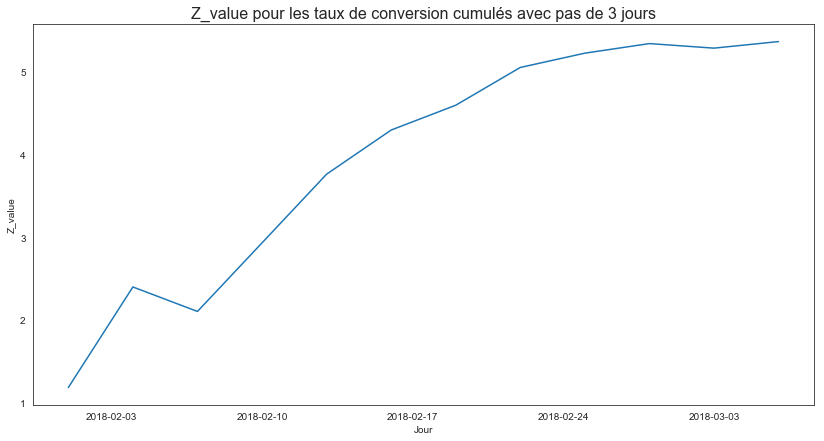

In [14]:
def cumulated_dataset_freq(dataset, frequency):  # dataset cumulé avec un pas de frequency jours
    cumulated_dataset = dataset.resample(frequency).sum().cumsum()
    cumulated_dataset['conv_rate'] = cumulated_dataset['n_convs'] / cumulated_dataset['total_impressions']
    return cumulated_dataset

frequency = '3D'

cumulated_datasetA = cumulated_dataset_freq(datasetA, frequency)
cumulated_datasetB = cumulated_dataset_freq(datasetB, frequency)

Z_value_3D = []
p_value_3D = []

for date in cumulated_datasetA.index:
    pA = cumulated_datasetA.loc[date]['conv_rate']
    nA = cumulated_datasetA.loc[date]['total_impressions']
    pB = cumulated_datasetB.loc[date]['conv_rate']
    nB = cumulated_datasetB.loc[date]['total_impressions']
    Z_value_3D.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value_3D.append(1 - norm.cdf(abs(Z_value_3D[-1])) + norm.cdf(-abs(Z_value_3D[-1])))
    
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(cumulated_datasetA.index, Z_value_3D)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title(f'Z_value pour les taux de conversion cumulés avec pas de {frequency[0]} jours', fontsize=16)
plt.show()

L'évolution de la Z-value est ainsi similaire à celle trouvée avec un pas quotidien. En effet, en prenant une fenêtre temporelle plus large pour regarder le cumul des données, on obtient une courbe plus lissée car celle-ci agrège les données à un plus haut niveau. L'allure reste toutefois semblable à celle où la fenêtre est plus réduite (et donc plus précise). Intéressons maintenant l'évolution de la p-value : **une fenêtre temporelle de 3 jours pour le cumul des données change-t-il la significativité du test, et donc la conclusion finale ?**

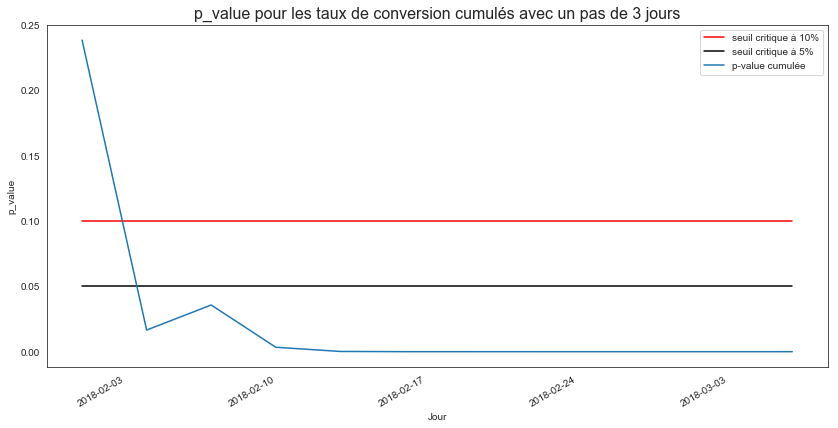

In [15]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(cumulated_datasetA.index, [0.1]*len(cumulated_datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(cumulated_datasetA.index, [0.05]*len(cumulated_datasetA.index), marker='', linestyle='-', c='black')
plt.plot(cumulated_datasetA.index, p_value_3D)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title(f'p_value pour les taux de conversion cumulés avec un pas de {frequency[0]} jours', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

Une fois de plus, on voit que la p-value du Z-test cumulé chute brutalement au début de la campagne publicitaire : cela signifie que dès le début, une version se démarque de l'autre par un taux de conversion sensiblement plus élevé. **Une observation globale des données à partir du 4 février suggère que la version A engendre un meilleur taux de conversion que la version B, et que cette remarque peut être affirmée avec un niveau de significativité quelconque (5%, 10% etc)**. De plus, la p-value restant très en-dessous du seuil critique à 5% pour toute la durée du test, on peut aussi affirmer qu'**à n'importe quel moment postérieur au 4 février, la version A était meilleure que la version B en termes de taux de conversion**.

# Modèles ARMA pour prédiction de la Z-value et p-value

### Z-valeur

In [57]:
Z_cum = pd.Series(Z_value_1D)
Z_cum.index = daily_cumsum_datasetA.index
series = Z_cum

def arma_model_selection_stationary(series, max_ar=4, max_ma=4):
    assert not series.isnull().any()
    order_select = sto.arma_order_select_ic(
        Z_cum.values,
        ic=['aic', 'bic'],
        max_ar=max_ar,
        max_ma=max_ma
    )
    
    ### AIC ###
    order_aic = order_select['aic'].values
    list_aic = [order_select['aic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_aic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_aic = [x for _,x in sorted(zip(list_aic,list_order_aic))]
    list_aic.sort()
    
    order_aic_stationary = None
    
    for order_aic in list_order_aic:
        try:
            ARIMA(series.values, order=(order_aic[0], 0, order_aic[1])).fit()
            order_aic_stationary = order_aic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    aic_stationary = list_aic[list_order_aic.index(order_aic_stationary)]
    
    ### BIC ###
    order_bic = order_select['bic'].values
    list_bic = [order_select['bic'][i][j] for j in range(0, max_ar+1) for i in range(0, max_ma+1)]
    list_order_bic = [(j,i) for j in range(0,max_ar+1) for i in range(0, max_ma+1)]
    
    list_order_bic = [x for _,x in sorted(zip(list_bic,list_order_bic))]
    list_bic.sort()
    
    order_bic_stationary = None
    
    for order_bic in list_order_bic:
        try:
            ARIMA(series.values, order=(order_bic[0], 0, order_bic[1])).fit()
            order_bic_stationary = order_bic
            break
        except Exception as e:
            if isinstance(e, ValueError):
                pass
    
    bic_stationary = list_bic[list_order_bic.index(order_bic_stationary)]
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(order_select["aic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats AIC")

    plt.subplot(1, 2, 2)
    sns.heatmap(order_select["bic"])
    plt.xlabel("Ordre MA")
    plt.ylabel("Ordre AR")
    plt.title("Résultats BIC")

    plt.suptitle(f"max_ar={max_ar}, max_ma={max_ma}")
    plt.show();

    print(
        "AIC meilleur modèle stationnaire : AR={}, MA={}, AIC={} ".format(
            order_aic_stationary[0], order_aic_stationary[1],
            aic_stationary
        )
    )
    print(
        "BIC meilleur modèle stationnaire : AR={}, MA={}, BIC={} ".format(
            order_bic_stationary[0], order_bic_stationary[1],
            bic_stationary
        )
    )

    return order_aic_stationary, order_bic_stationary

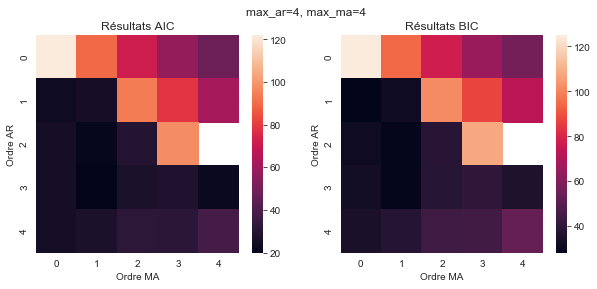

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=19.86927751102526 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


In [58]:
##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

Le modèle suggéré par minimisation du critère AIC est un modèle ARMA(3,1) tandis que la miniisation du critère BIC suggère un modèle AR(1).

# Meilleur modèle selon AIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(3, 1)   Log Likelihood                  -3.935
Method:                       css-mle   S.D. of innovations              0.245
Date:                Wed, 20 Feb 2019   AIC                             19.869
Time:                        19:26:06   BIC                             29.027
Sample:                             0   HQIC                            22.992
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7942      0.983      2.842      0.008       0.867       4.721
ar.L1.y        1.6647      0.165     10.061      0.000       1.340       1.989
ar.L2.y       -0.3470      0.331     -1.049      0

## Erreurs

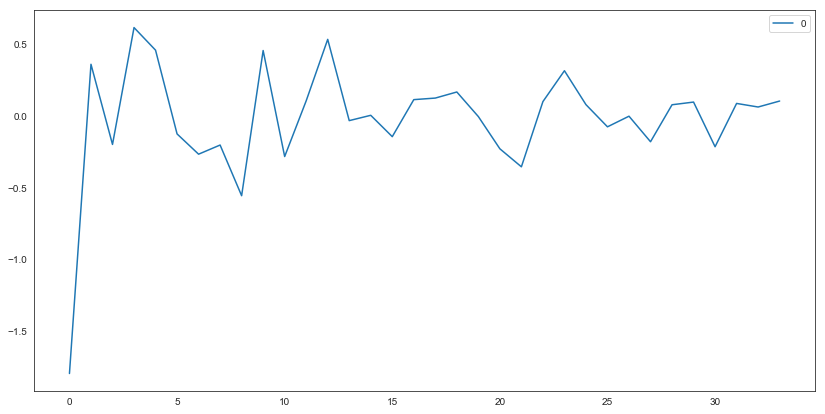

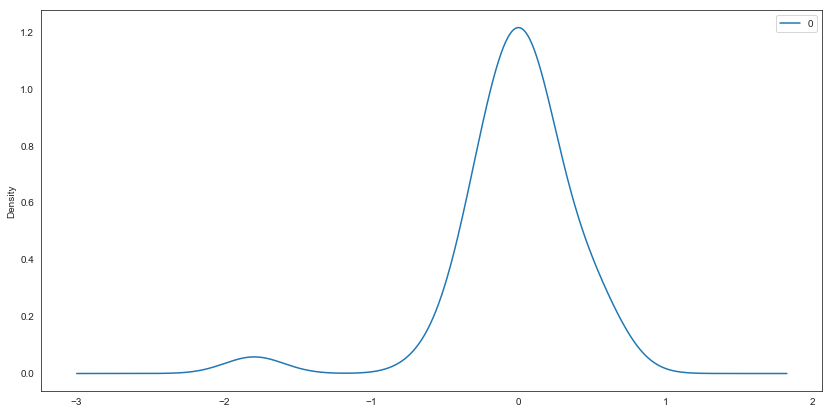

               0
count  34.000000
mean   -0.022562
std     0.407415
min    -1.794244
25%    -0.192852
50%     0.034435
75%     0.112647
max     0.617006


# Meilleur modèle selon BIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  -8.815
Method:                       css-mle   S.D. of innovations              0.296
Date:                Wed, 20 Feb 2019   AIC                             23.630
Time:                        19:26:06   BIC                             28.209
Sample:                             0   HQIC                            25.192
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2795      1.857      1.766      0.087      -0.360       6.919
ar.L1.y        0.9891      0.014     68.508      0.000       0.961       1.017
                                    Roots         

## Erreurs

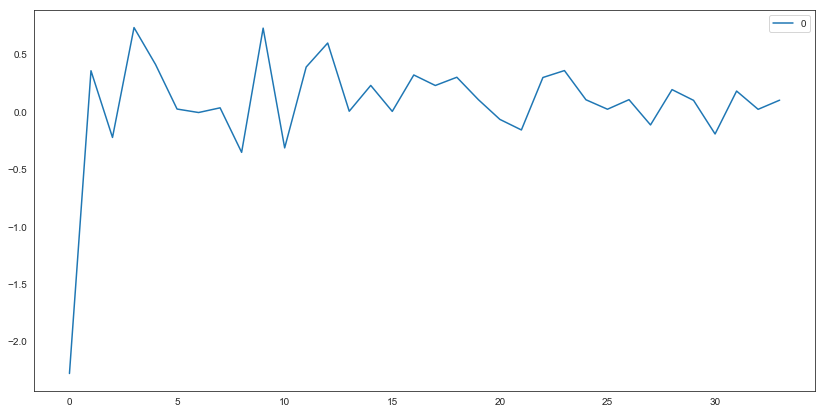

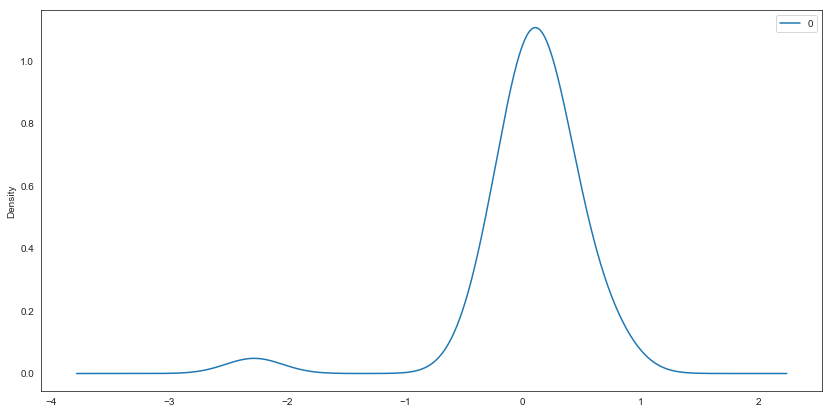

               0
count  34.000000
mean    0.066313
std     0.489928
min    -2.279459
25%    -0.003815
50%     0.103102
75%     0.300396
max     0.733639


In [59]:
display(Markdown("# Meilleur modèle selon AIC"))
testARMA(Z_cum.values, p=aic_min_order[0], d=0, q=aic_min_order[1])

display(Markdown("# Meilleur modèle selon BIC"))
testARMA(Z_cum.values, p=bic_min_order[0], d=0, q=bic_min_order[1])

### p-valeur

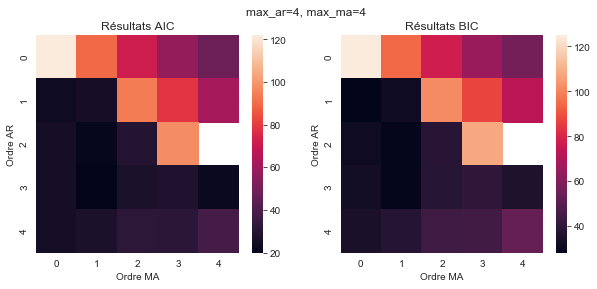

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=23.63014996802002 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


In [60]:
P_rej = pd.Series(p_value_1D)
P_rej.index = daily_cumsum_datasetA.index
series = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(P_rej, max_ar=max_ar, max_ma=max_ma)

Les critères AIC et BIC suggèrent un modèle AR(1) pour la modélisation de la p-value.

# Meilleur modèle selon AIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  57.006
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 20 Feb 2019   AIC                           -108.013
Time:                        19:26:34   BIC                           -103.434
Sample:                             0   HQIC                          -106.451
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0850      0.090      0.943      0.353      -0.092       0.262
ar.L1.y        0.9312      0.075     12.466      0.000       0.785       1.078
                                    Roots         

## Erreurs

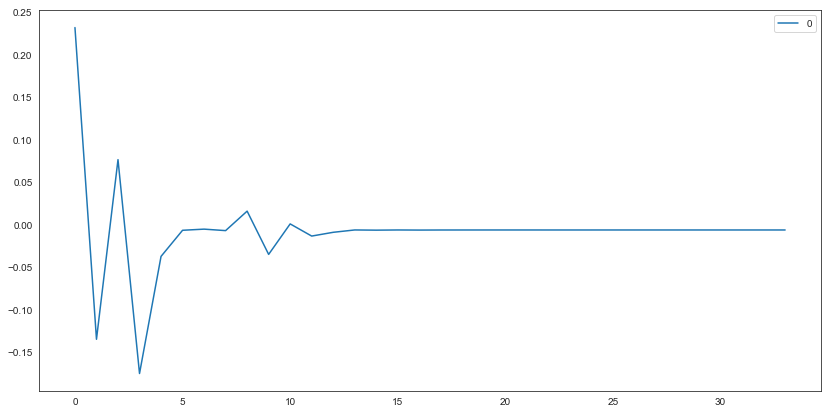

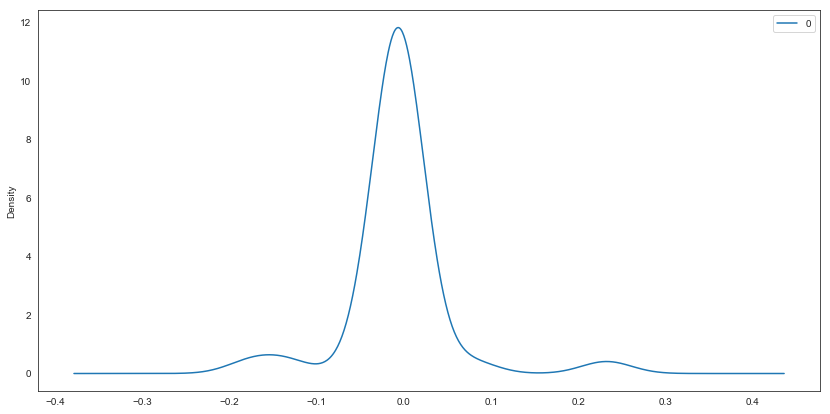

               0
count  34.000000
mean   -0.006362
std     0.058002
min    -0.174735
25%    -0.006036
50%    -0.005850
75%    -0.005849
max     0.232315


# Meilleur modèle selon BIC

## Fit du modèle



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 0)   Log Likelihood                  57.006
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 20 Feb 2019   AIC                           -108.013
Time:                        19:26:34   BIC                           -103.434
Sample:                             0   HQIC                          -106.451
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0850      0.090      0.943      0.353      -0.092       0.262
ar.L1.y        0.9312      0.075     12.466      0.000       0.785       1.078
                                    Roots         

## Erreurs

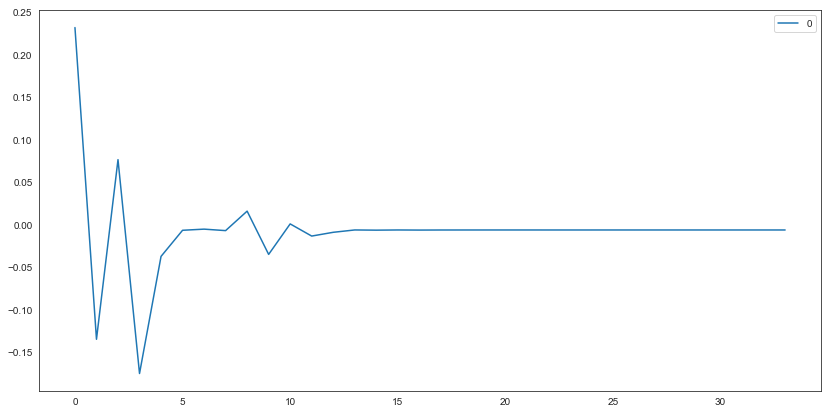

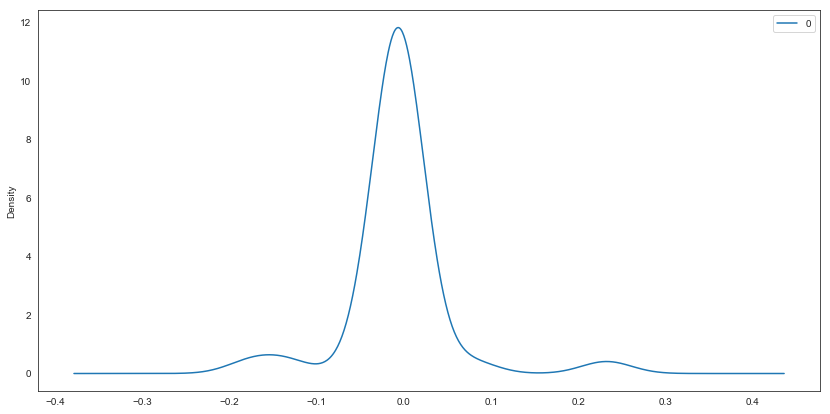

               0
count  34.000000
mean   -0.006362
std     0.058002
min    -0.174735
25%    -0.006036
50%    -0.005850
75%    -0.005849
max     0.232315


In [61]:
display(Markdown("# Meilleur modèle selon AIC"))
testARMA(P_rej.values, p=aic_min_order[0], d=0, q=aic_min_order[1])

display(Markdown("# Meilleur modèle selon BIC"))
testARMA(P_rej.values, p=bic_min_order[0], d=0, q=bic_min_order[1])

# Prédictions sur les données empiriques pour arrêt de test anticipé

L'idée est ici de tronquer la série chronologique de Z ou P à un instant t avant la fin de la campagne et de lui faire correspondre un modèle dans le but de savoir s'il est possible d'arrêter le test avant. (question budgétaire)

### train ratio de 0.5

In [89]:
train_ratio = 0.5
t = round(train_ratio*len(Z_cum))
Z_tronq = Z_cum[:t]
P_tronq = P_rej[:t]

#### Z-value

Z_tronq


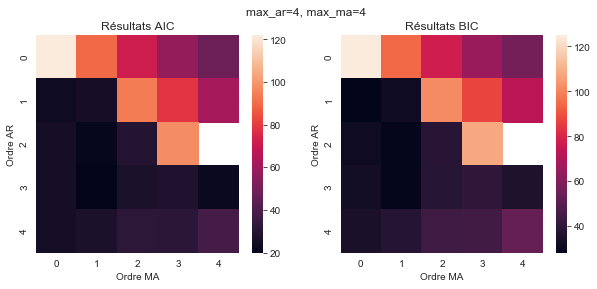

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=19.86927751102526 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


In [90]:
series = Z_tronq

print("Z_tronq")

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    Z_tronq.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

## MSE Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(3, 1)   Log Likelihood                  -6.788
Method:                       css-mle   S.D. of innovations              0.312
Date:                Wed, 20 Feb 2019   AIC                             25.575
Time:                        21:17:56   BIC                             30.575
Sample:                    02-01-2018   HQIC                            26.072
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4940      0.616      4.047      0.002       1.286       3.702
ar.L1.y        1.5860      0.231      6.868      0.000       1.133       2.039
ar.L2.y       -0.

## Erreurs

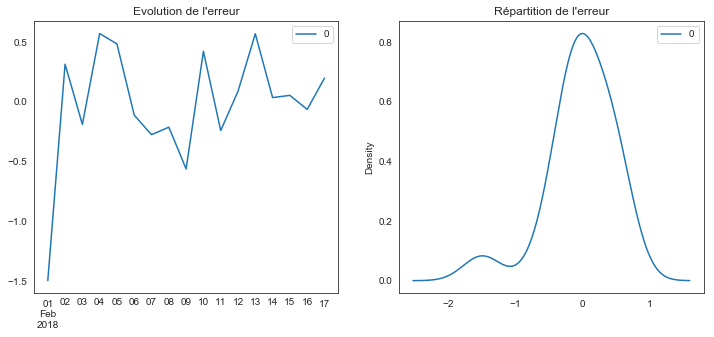

In [76]:
def arma_select_mse(y,max_ar = 2,max_ma=2,d = 0):
    MSE = np.zeros((max_ar +1,max_ma +1) )
    for p in range(max_ar + 1):
        for q in range(max_ma + 1):
            try :
                md = ARIMA(y, order=(p, d, q)).fit()
                MSE[p,q] = sum(np.array(md.resid)**2)
            except:
                MSE[p,q] = float('Inf')
                continue  #not raising exceptions if non invertible or non causal models
            
    mse_min_order = np.nanargmin(MSE)//MSE.shape[1], np.nanargmin(MSE)%MSE.shape[1] 
    return mse_min_order

mse_min_order = arma_select_mse(Z_tronq.values,max_ar=4,max_ma=4)
display(Markdown("## MSE Best Model"))
print('\n')

d = 0
p, q = mse_min_order[0], mse_min_order[1]
######################################################################################

print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


## AIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(3, 1)   Log Likelihood                  -6.788
Method:                       css-mle   S.D. of innovations              0.312
Date:                Wed, 20 Feb 2019   AIC                             25.575
Time:                        21:19:23   BIC                             30.575
Sample:                    02-01-2018   HQIC                            26.072
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4940      0.616      4.047      0.002       1.286       3.702
ar.L1.y        1.5860      0.231      6.868      0.000       1.133       2.039
ar.L2.y       -0.

## Erreurs

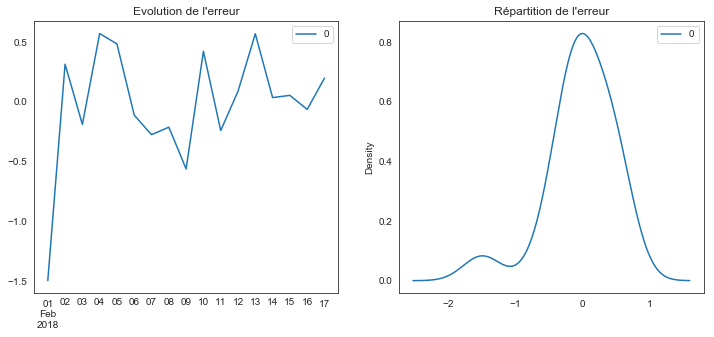

In [77]:
##################################### PARAMETRES #####################################
d = 0

display(Markdown("## AIC Best Model"))
print('\n')
p, q = aic_min_order[0], aic_min_order[1]
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()

## BIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  -9.064
Method:                       css-mle   S.D. of innovations              0.384
Date:                Wed, 20 Feb 2019   AIC                             24.127
Time:                        21:20:02   BIC                             26.627
Sample:                    02-01-2018   HQIC                            24.376
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5557      1.100      2.323      0.035       0.399       4.712
ar.L1.y        0.9546      0.059     16.245      0.000       0.839       1.070
                 

## Erreurs

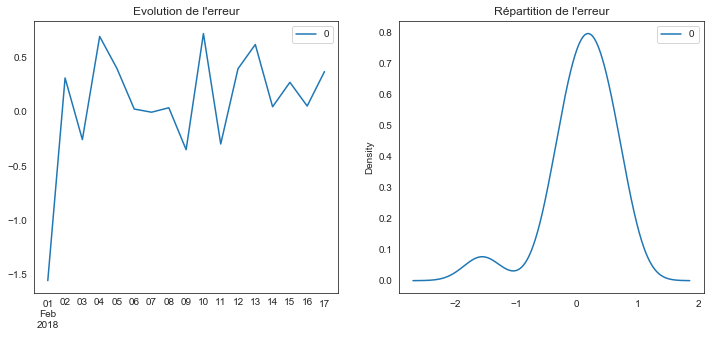

In [78]:
##################################### PARAMETRES #####################################
d = 0

display(Markdown("## BIC Best Model"))
print('\n')
p, q = bic_min_order[0], bic_min_order[1]
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", Z_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(Z_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()

MSE best model : (3, 1)
AIC best model : (3, 1)
BIC best model : (1, 0)


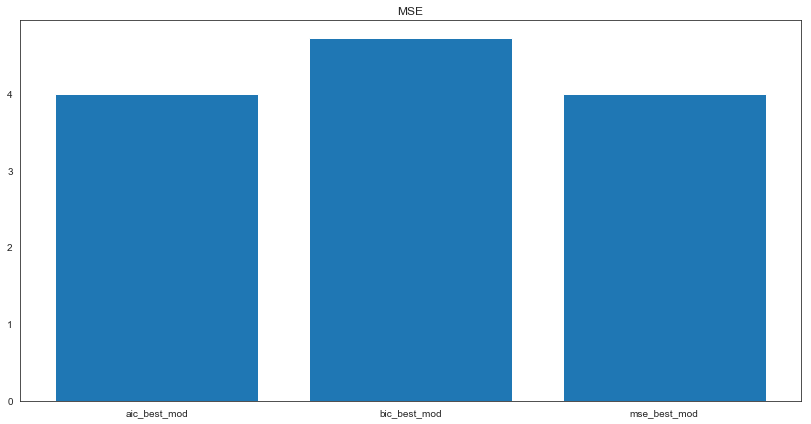

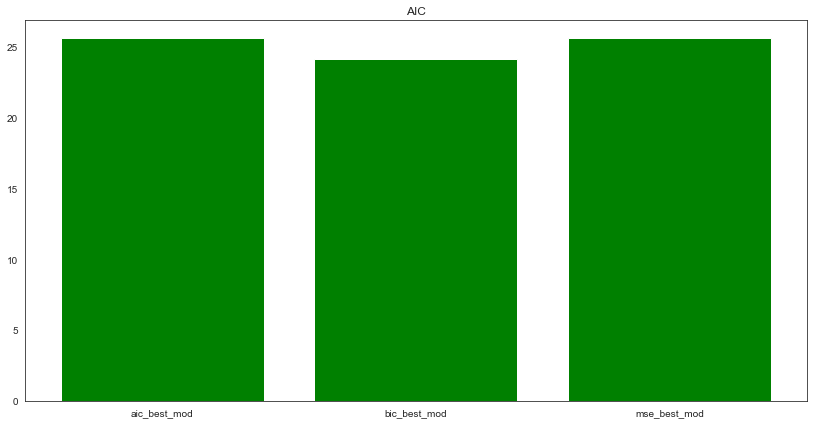

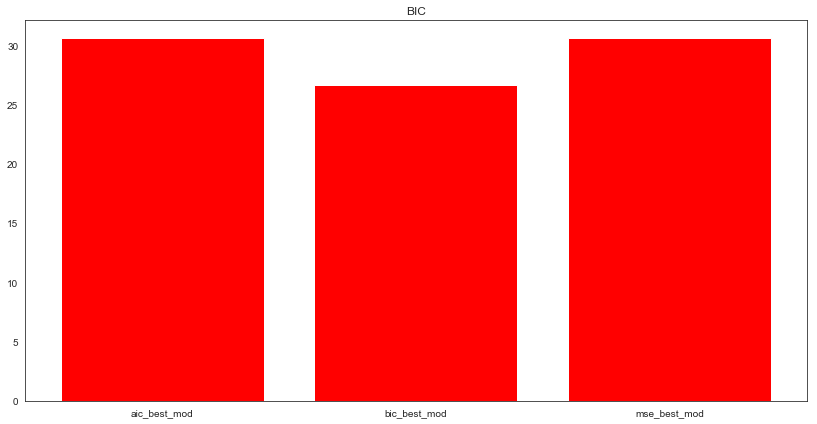

In [79]:
comparaison_model(aic_min_order,bic_min_order,mse_min_order,Z_tronq)

On voit que la minimisation par AIC et par MSE conduisent à choisir un modèle ARMA(3,1) avec des valeurs sensiblement similaires pour tous les critères de comparaison. Le critère BIC suggère quant à lui un modèle AR(1).

#### p-valeur

P_tronq


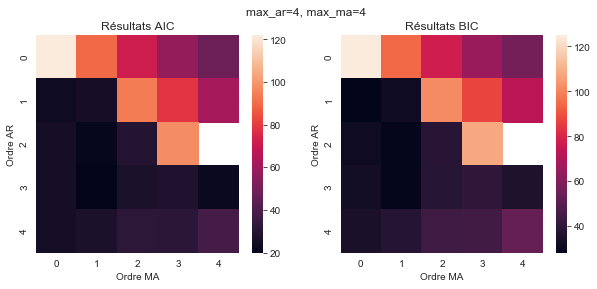

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=23.63014996802002 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


In [80]:
series = P_tronq

print("P_tronq")

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = sto.arma_order_select_ic(
    series.values,
    ic = ['aic', 'bic'],
    max_ar=max_ar, 
    max_ma=max_ma
)

aic_min_order, bic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)

## AIC and BIC Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(1, 0)   Log Likelihood                  22.371
Method:                       css-mle   S.D. of innovations              0.062
Date:                Wed, 20 Feb 2019   AIC                            -38.742
Time:                        21:26:14   BIC                            -36.243
Sample:                    02-01-2018   HQIC                           -38.494
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0976      0.089      1.100      0.289      -0.076       0.271
ar.L1.y        0.8618      0.143      6.029      0.000       0.582       1.142
                 

## Erreurs

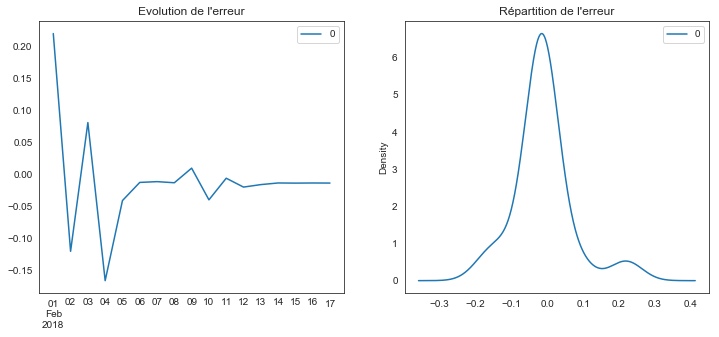

In [82]:
##################################### PARAMETRES #####################################
d = 0
display(Markdown("## AIC and BIC Best Model"))
print('\n')
p, q = 1, 0
######################################################################################

# asfreq permettra de faire des predictions et de les afficher facilement...
# ffill au cas ou il manque des jours... 
# mais faire très attention aux datasets où il manque une grosse plage de journées!
# genre a1c1 vers la fin... donc je mets une limite au nb max de jours manquants
print("Attention, ", P_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_p_t = ARIMA(P_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_p_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_p_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


## MSE Best Model



Attention,  0  journées avec NaN
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   17
Model:                     ARMA(0, 2)   Log Likelihood                  24.347
Method:                       css-mle   S.D. of innovations              0.051
Date:                Wed, 20 Feb 2019   AIC                            -40.694
Time:                        21:27:46   BIC                            -37.361
Sample:                    02-01-2018   HQIC                           -40.363
                         - 02-17-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0584      0.029      2.037      0.061       0.002       0.115
ma.L1.y        0.4641      0.199      2.332      0.035       0.074       0.854
ma.L2.y        0.

## Erreurs

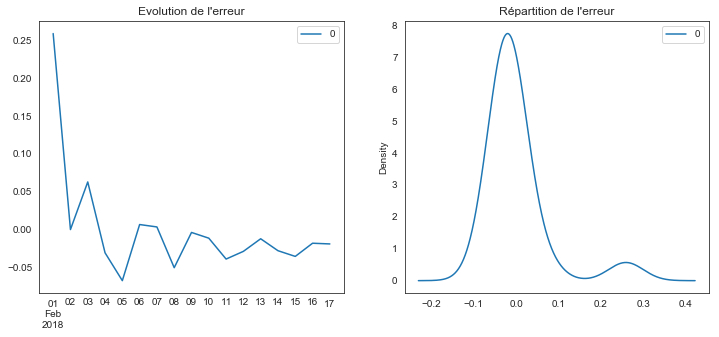

In [83]:
mse_min_order = arma_select_mse(P_tronq.values,max_ar=4,max_ma=4)
display(Markdown("## MSE Best Model"))
print('\n')

d = 0
p, q = mse_min_order[0], mse_min_order[1]
######################################################################################

print("Attention, ", P_tronq.asfreq("D").isna().sum(), " journées avec NaN")

model_z_t = ARIMA(P_tronq.asfreq("D").fillna(method="ffill"), order=(p, d, q), freq="D").fit()
# model_fit = model.fit(disp=0)
print(model_z_t.summary())
# print(model_fit.summary())
display(Markdown("## Erreurs"))
print('\n')
residuals = DataFrame(model_z_t.resid)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
residuals.plot(ax=plt.gca())
plt.title("Evolution de l'erreur")

plt.subplot(1, 2, 2)
residuals.plot(kind='kde', ax=plt.gca())
plt.title("Répartition de l'erreur")

plt.show()


MSE best model : (0, 2)
AIC best model : (1, 0)
BIC best model : (1, 0)


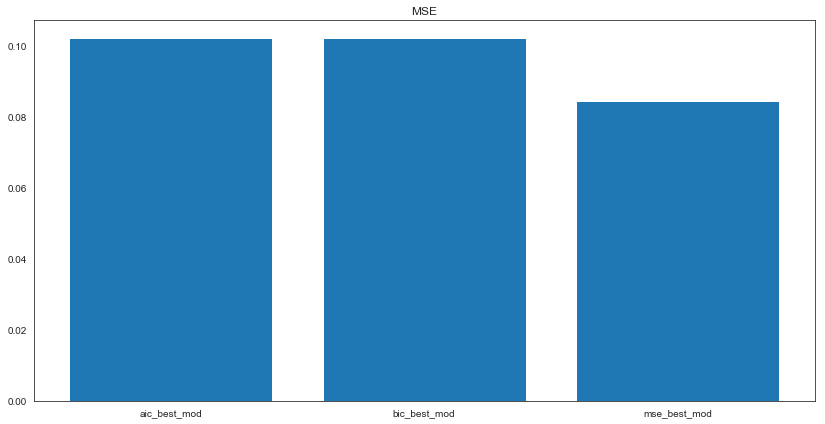

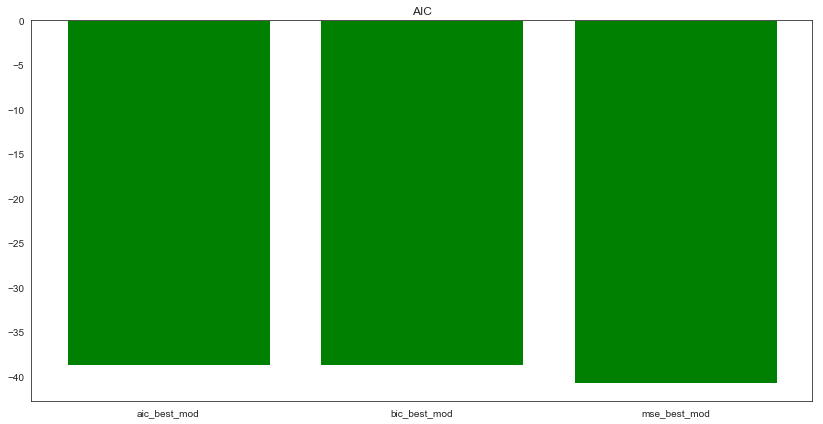

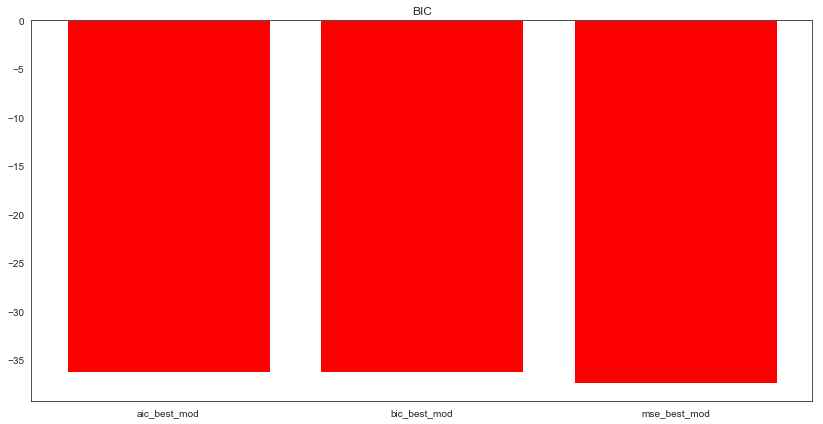

In [84]:
comparaison_model(aic_min_order,bic_min_order,mse_min_order,P_tronq)

Pour la p-valeur, les critères AIC et BIC suggèrent un modèle AR(1) tandis que la minimisation de la MSE conduit à choisir un modèle MA(2).

## Prédiction

Quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées

In [98]:
def out_of_sample_prediction(p, q, y_true, train_ratio, signif=True, graph=True, alpha=0.05):
    t = round(train_ratio * len(y_true))
    train_data = y_true[:t]

    model = ARIMA(train_data, order=(p, 0, q)).fit()

    pred_start = t
    pred_end = len(y_true)

    pred_index = np.arange(pred_start + 1, pred_end + 1)
    
    forecast, stderr, conf_int = model.forecast(pred_end - pred_start, alpha=alpha)

    if graph == True:
        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(1, t + 1), train_data, label="Observed (train)", marker="o", ms=4)
        plt.plot(pred_index, y_true[t:], label="Test period (truth)", marker="o", ms=4)
        plt.plot(pred_index, forecast, label="Dynamic pred", marker="o", ms=4)
        # plt.plot(pred_index, one_step_ahead_predictions, label="1-step pred", marker="o", ms=4)
      
        # Intervalle de confiance au seuil 1-alpha
        plt.fill_between(pred_index, conf_int[:, 0], conf_int[:, 1], color='blue', alpha=0.25)

        plt.legend()
        plt.title(f"[train_ratio={train_ratio}] Resultats de prédiction pour AR={p} MA={q}")
    
        if signif == True:
            for threshold in [0.2, 0.1]:
                threshold_series = pd.Series(np.full(len(y_true), threshold))
                plt.plot(threshold_series, label=f"threshold={threshold}")
                # combien de fois on dépasse le seuil?
                print('Dépassement de la vraie série du seuil ( = significatif) à',threshold)
                print(sum(y_true[t:]<threshold))
                print('Dépassement de la prédiction dynamique du seuil ( = significatif) à',threshold)
                print(sum(forecast<threshold))
                plt.legend()
        plt.show()
    return forecast, conf_int

#### a. Z_valeur

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.25


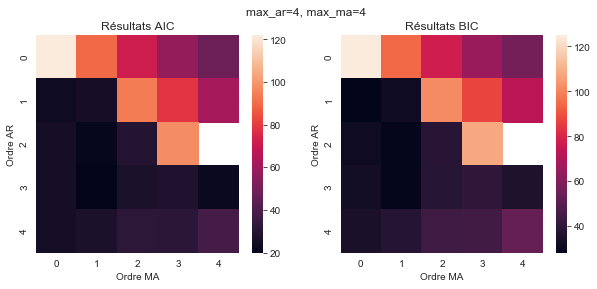

AIC meilleur modèle stationnaire : AR=2, MA=1, AIC=21.353990901730285 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


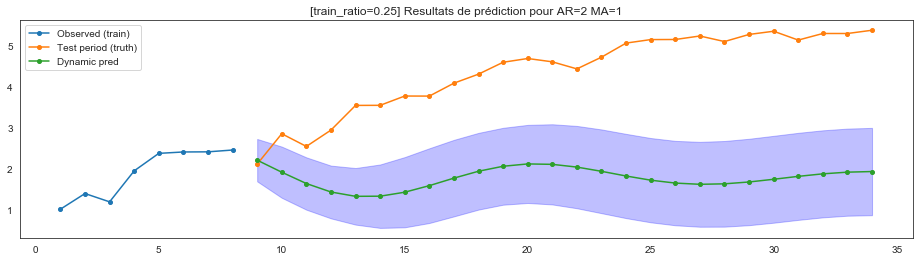

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.5


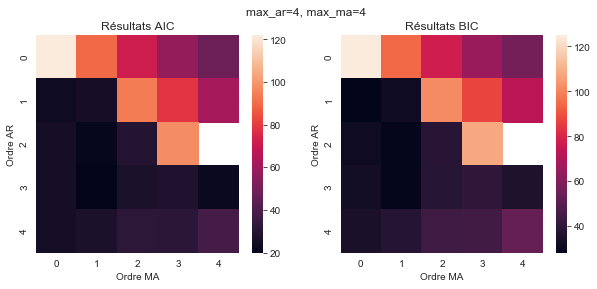

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=19.86927751102526 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


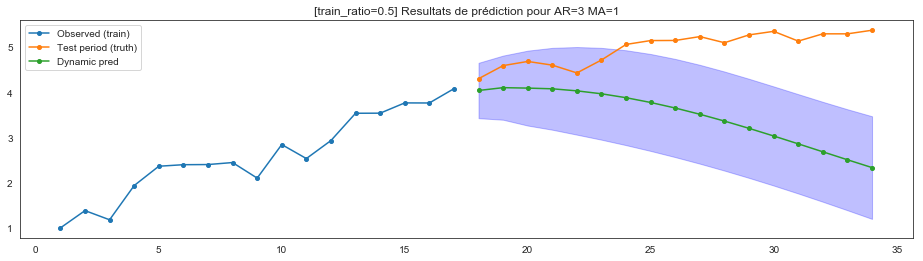

out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio= 0.65


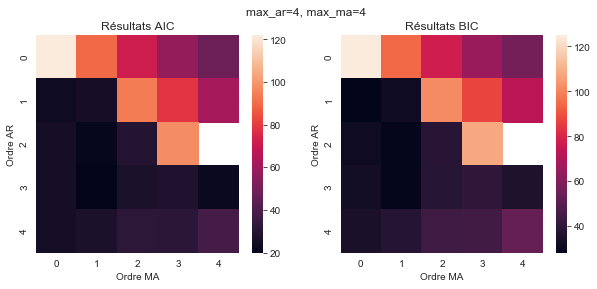

AIC meilleur modèle stationnaire : AR=2, MA=1, AIC=21.353990901730285 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 


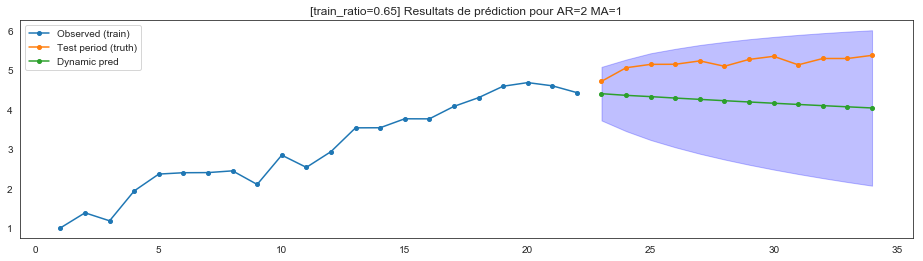

In [99]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("out_of_sample_prediction of Z_cum with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = Z_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=Z_cum,
                             train_ratio=train_ratio,signif=False)

#### p-valeur à partir de la Z-valeur prédite

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.25


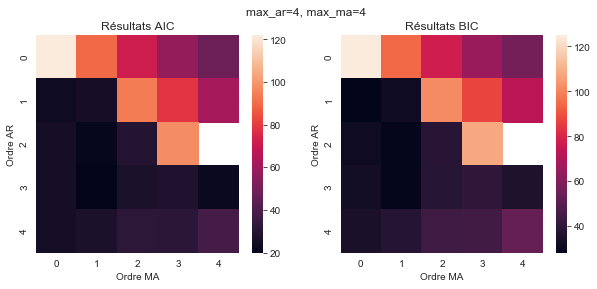

AIC meilleur modèle stationnaire : AR=2, MA=1, AIC=21.353990901730285 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
26
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
26
Dépassement de la vraie série du seuil ( = significatif) à 0.1
26
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
17


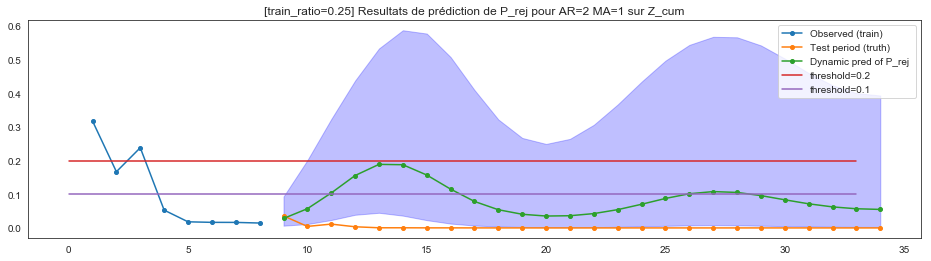

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.5


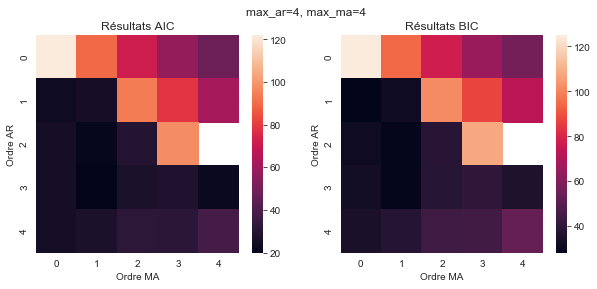

AIC meilleur modèle stationnaire : AR=3, MA=1, AIC=19.86927751102526 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
17
Dépassement de la vraie série du seuil ( = significatif) à 0.1
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
17


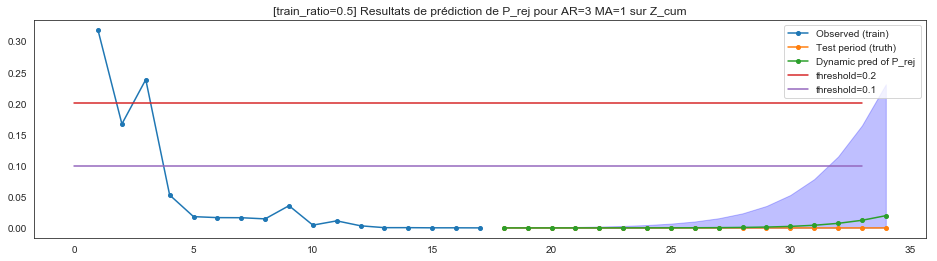

Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio= 0.65


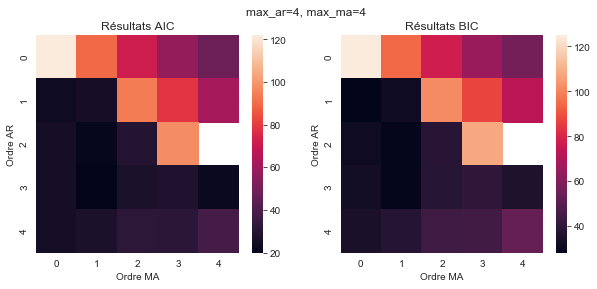

AIC meilleur modèle stationnaire : AR=2, MA=1, AIC=21.353990901730285 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
12
Dépassement de la vraie série du seuil ( = significatif) à 0.1
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
12


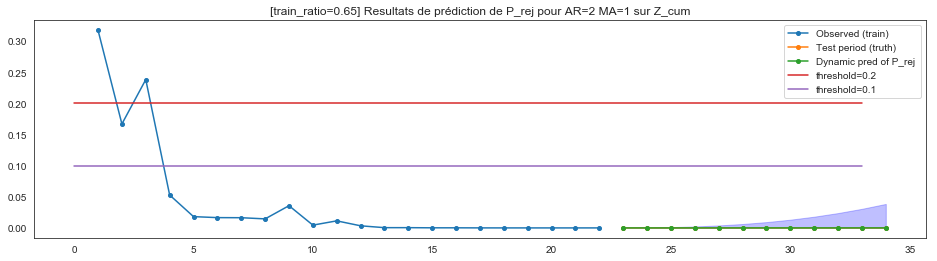

In [106]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("Prédiction de P_rej avec un modèle sur Z_cum with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = Z_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    p_with_fit_of_z(p=aic_min_order[0], q=aic_min_order[1], p_true = P_rej,z_true=Z_cum,
                    train_ratio=train_ratio,signif= True)

### p-valeur

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.25


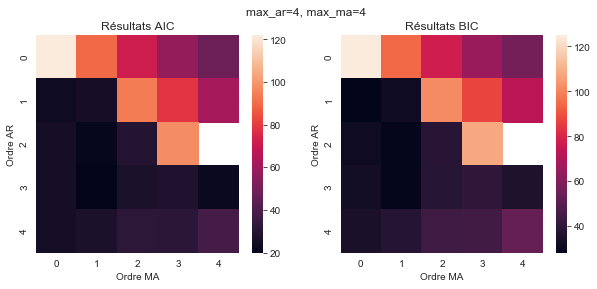

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=23.63014996802002 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
26
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
26
Dépassement de la vraie série du seuil ( = significatif) à 0.1
26
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
3


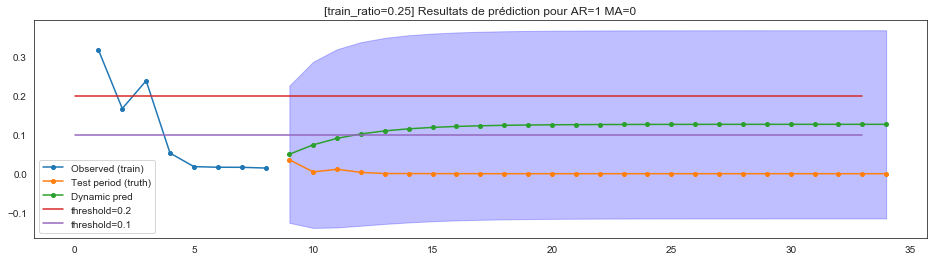

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.5


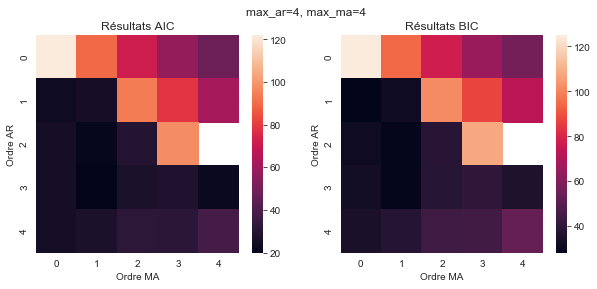

AIC meilleur modèle stationnaire : AR=1, MA=0, AIC=23.63014996802002 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
17
Dépassement de la vraie série du seuil ( = significatif) à 0.1
17
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
17


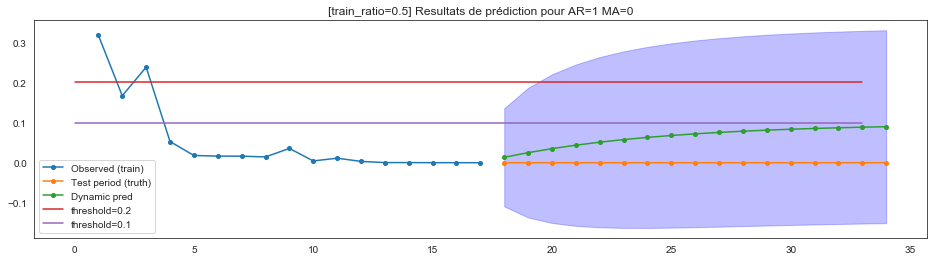

out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio= 0.65


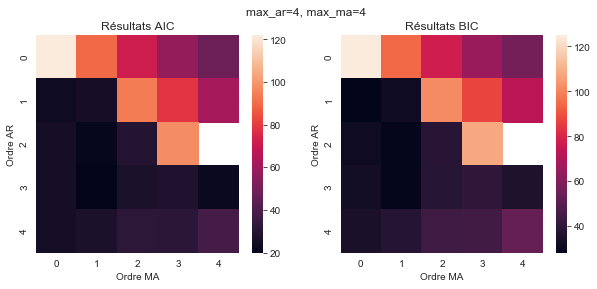

AIC meilleur modèle stationnaire : AR=3, MA=4, AIC=22.304699250658146 
BIC meilleur modèle stationnaire : AR=1, MA=0, BIC=28.209231541868505 
Dépassement de la vraie série du seuil ( = significatif) à 0.2
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.2
12
Dépassement de la vraie série du seuil ( = significatif) à 0.1
12
Dépassement de la prédiction dynamique du seuil ( = significatif) à 0.1
12


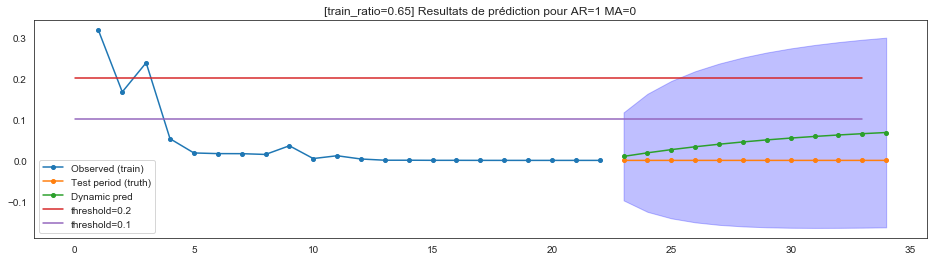

In [102]:
##################################### PARAMETRES #####################################
pred_start = 45  # debut des predictions
pred_end = 100  # fin des predictions
pred_start = 15
pred_end = None
######################################################################################
train_ratio_list = [0.25,0.5,0.65]
for train_ratio in train_ratio_list:
    print("out_of_sample_prediction of P_rej with 95% Confidence Interval, train_ratio=", train_ratio)
    
    t = round(train_ratio*len(Z_cum))
    Z_tronq = Z_cum[:t]
    P_tronq = P_rej[:t]
    series = P_tronq
    
    aic_min_order = arma_model_selection_stationary(series, max_ar=max_ar, max_ma=max_ma)[0]
    
    if train_ratio == 0.65:
        aic_min_order = (1,0)
        
    out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=P_rej,
                             train_ratio=train_ratio,signif= True)

Globalement, la prédiction reproduit à peu près le même comportement que la p-valeur, qu'elle soit calculée à partir des prédictions de la Z-valeur ou qu'elle soit prédite directement à partir de la p-valeur. Néanmoins, le modèle offre une incertitude qui fait dépasser la p-valeur au-delà des seuils critiques de significativité, si bien qu'il est difficile de statuer sur la qualité des prédictions.